ML in Production
=========

So far we have been looking at building a machine learning model,
while this is nice we actually want to be able to use it
to perform useful science.

This notebook will demonstrate the application of the machine learning algorithm
that we built in the first part of the tutorial to
the classification of a previously unseen configuration.

Loading the Model
----------------

At the end of the [previous notebook](02_Lets_Find_A_Model.ipynb)
we saved the model as a python pickle using scikit-learn's `joblib` library.
This converted the in memory object that represented the trained state
of the machine learning algorithm into a form that could be saved to disk.
By reading the file `knn-model.pkl` from disk,
we can load the trained K-Nearest Neighbours model.

In [1]:
from sklearn.externals import joblib
model = joblib.load('data/knn-model.pkl')
model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

With the model now loaded we need some data to apply it to.
For this we need to load a configuration and
compute the relative orientation of all the neareset neighbours.
With the nearest neighbour orientations comptued,
all that is left to do is use the model to predict the classes.

In [2]:
import gsd.hoomd
from pathlib import Path
from statdyn.analysis.order import relative_orientations

with gsd.hoomd.open('data/unknown/configuration.gsd') as trj:
    snap = trj[0]
orientations = relative_orientations(snap.configuration.box,
                           snap.particles.position,
                           snap.particles.orientation,
                           max_neighbours=6,
                           max_radius=3.5)
classes = model.predict(orientations)
classes

array(['liq', 'liq', 'liq', ..., 'liq', 'liq', 'liq'], dtype=object)

With the classification in hand we can perform any number of analyses.
Below I am taking the classes array and using pandas
to generate a histogram of the data.
We can see that most of the configuration is liquid,
there are large amounts of both the p2 and p2gg crystals, and 
a small number of pg crystals.

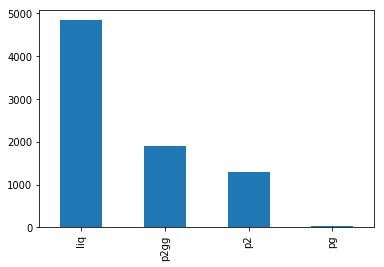

In [7]:
import pandas
%matplotlib inline

pandas.Series(classes).value_counts().plot(kind='bar')

If we want a better understanding of the configuration,
we can plot the configuration in the notebook,
colouring by the classification.
For this I am using [bokeh](https://bokeh.pydata.org/en/latest/)
since it allows interacting with the dataset by panning a zooming,
allowing for both an overview and investigation in a single figure. 

In [4]:
import numpy as np
from bokeh.plotting import show, output_notebook, figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Colorblind4 as palette
from statdyn.figures.configuration import plot_circles, snapshot2data

# Output the final figure to the jupyter notebook
output_notebook()

# The colours we will assign each class
class_colours = {
    'liq': palette[0],
    'p2': palette[1],
    'p2gg': palette[2],
    'pg': palette[3],
}

# Convert the class strings to a colour for plotting
coloured_classes = [class_colours[c] for c in classes]

# Convert the snapshot to format ready for plotting 
data = snapshot2data(snap) 
data['colour'] = np.tile(coloured_classes, 3)
data['label'] = np.tile(classes, 3)
source = ColumnDataSource(data)

# Create the figure
p = figure(aspect_scale=1, match_aspect=True, width=920, height=800, active_scroll='wheel_zoom')
p.circle('x', 'y', radius='radius', source=source, color='colour', legend='label')

show(p)

Loading BokehJS ...